In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv3D, MaxPooling3D
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

IMAGE_HEIGHT, IMAGE_WIDTH = 240, 240
TUMOR_IMAGES = 155
AGE_CLASSES = 100
MAX_SURVIVAL = 2000
df = pd.read_csv("data/survival_data.csv")
df.head()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15288776373839293115
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 242221056
locality {
  bus_id: 1
}
incarnation: 1558136142775106907
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0"
]


,Brats17ID,Age,Survival
0,Brats17_TCIA_167_1,74.907,153
1,Brats17_TCIA_242_1,66.479,147
2,Brats17_TCIA_319_1,64.860,254
3,Brats17_TCIA_469_1,63.899,519
4,Brats17_TCIA_218_1,57.345,346


In [2]:
X = np.load('data/tumors_nz.npy')
X = X[:, 14:143, :, :, :] # All images from 0 to 15 and 144 to the end are totally black
Y = df['Survival']

array([0, 1], dtype=uint8)

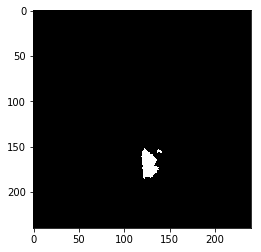

In [3]:
plt.imshow(X[100, 77, 0, :, :], cmap='gray')
np.unique(X[100, 77, 0, :, :])

In [56]:
def get_splitted_data(X, ages, labels):
    assert len(X) == len(labels) == len(ages)
    # OneHotEncoding for ages
    enc_table = np.eye(AGE_CLASSES)
    ages_ohe = np.array([enc_table[int(round(x))] for x in ages])
    # Normalize labels
    labels /= MAX_SURVIVAL
    # Split data into: 70% train, 15% test, 15% validation
    cuts = [int(.70*len(X)), int(.85*len(X))]
    X1_train, X1_test, X1_val = np.split(X, cuts)
    X2_train, X2_test, X2_val = np.split(ages_ohe, cuts)
    Y_train, Y_test, Y_val = np.split(labels, cuts)
    return X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, X1_val, X2_val, Y_val

X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, X1_val, X2_val, Y_val = get_splitted_data(X, df['Age'], df['Survival'])

In [58]:
with tf.device('/gpu:0'):
    
    main_input = Input(shape=X.shape[1:], dtype='float32', name='main_input')
    x = Conv3D(16, (3, 3, 3), padding='same', activation='relu')(main_input)
    x = Conv3D(16, (3, 3, 3), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 1, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv3D(32, (3, 3, 3), padding='same', activation='relu')(x)
    x = Conv3D(32, (3, 3, 3), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 1, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    cnn_out = Dense(64, activation='relu')(x)
    # auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(cnn_out)
    
    auxiliary_input = Input(shape=(AGE_CLASSES,), name='aux_input', dtype='float32')
    x = keras.layers.concatenate([cnn_out, auxiliary_input])
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])  # , auxiliary_output
    
    # RMSprop uses:
    # - Momentum taking knowledge from previous steps into account about where
    #   we should be heading (prevents gradient descent to oscillate)
    # - Uses recent gradients to adjust alpha
    #   (when the gradient is very large, alpha is reduced and vice-versa)
    # Later we should test if AdaDelta or Adam are improving our results (quite similar to RMSprop)
    model.compile(optimizer='Adam',
                  metrics=['accuracy'],
                  loss={'main_output': 'mean_squared_error'},  # 'aux_output': 'mean_squared_error'
                  loss_weights={'main_output': 1.})  # , 'aux_output': 0.2

    # And trained it via:
    model.fit({'main_input': X1_train, 'aux_input': X2_train},
              {'main_output': Y_train},  # 'aux_output': Y
              epochs=50, batch_size=32, verbose=1,
              validation_data=({'main_input': X1_test, 'aux_input': X2_test}, Y_test))

Train on 114 samples, validate on 24 samples
Epoch 1/50
114/114 [==============================] - 10s - loss: 318350.5620 - acc: 0.0000e+00 - val_loss: 212980.3438 - val_acc: 0.0000e+00
Epoch 2/50
114/114 [==============================] - 7s - loss: 318237.8766 - acc: 0.0000e+00 - val_loss: 212980.3438 - val_acc: 0.0000e+00
Epoch 3/50
 32/114 [=======>......................] - ETA: 4s - loss: 267642.6875 - acc: 0.0000e+00

KeyboardInterrupt: 

In [52]:
for i in range(5):
    prediction = int(model.predict({'main_input': X[i:i+1], 'aux_input': ages_ohe[i:i+1]}) * MAX_SURVIVAL)
    print('Patient: {}, Age: {}, GT: {}, Prediction: {}'.format(df.values[i, 0], df.values[i, 1], df.values[i, 2], prediction))

Patient: Brats17_TCIA_167_1, Age: 74.907, GT: 153, Prediction: 349
Patient: Brats17_TCIA_242_1, Age: 66.479, GT: 147, Prediction: 336
Patient: Brats17_TCIA_319_1, Age: 64.86, GT: 254, Prediction: 453
Patient: Brats17_TCIA_469_1, Age: 63.899, GT: 519, Prediction: 582
Patient: Brats17_TCIA_218_1, Age: 57.345, GT: 346, Prediction: 519


### 163 patients with tumor images of sizes 240x240 of which we have 155

### Start
Implementing a concatenated model as shown in the Docs: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
The model uses a small common CNN for processing one patient (155 slices x 128 width x 128 height) and just inserts the age at a certain point. With this simple model we get really bad results (main_output_loss: 263381.5156 [not getting better]).


### Possible improvements
1. ~~Conv3D (in CNN) which gets a 4D input - therefore add the tumor region as a dimension (transform input image into three images containing each tumor region seperately~~)
2. ~~One-hot encoder (in sklearn or implement manually)
  [ I tried Keras Lambda layer but after fixing the shapes keras told me that I'm not allowed to concatenate with a non input layer ]~~
3. Group ages into few classes changing the regression task into a classification task (with softmax).
4. Evaluate if LSTM is useful for this task (before concatenating the two branches or as a concatenator?)
5. Evaluate our optimizer (RMSprp vs Adam vs AdaDelta)
    -> RMSprop doesn't learn at all (Adam does!)
    -> First run was without normalization but no improvement (After normalization quite good results)
6. I red full batch learning is the best way for training on few training data - check if this is helpful.
7. Use for a patient nx, ny and nz at the same time
8. Data augmentation?